**Question:** 

Image Captioning : Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions. The dataset will be in the form [image → captions]. The dataset consists of input images and their corresponding output captions.

**Encoder**

The Convolutional Neural Network(CNN) can be thought of as an encoder. The input image is given to CNN to extract the features. The last hidden state of the CNN is connected to the Decoder.

**Decoder**

The Decoder is a Recurrent Neural Network(RNN) which does language modelling up to the word level. The first time step receives the encoded output from the encoder and also the <START> vector.

 

Read the pickle or token file  (https://www.kaggle.com/waelboussbat/flickr8ksau) {***filename***: Flickr8k.token.txt => set_0.pkl} and convert the data into the correct format which could be used for ML model. 

Pickle file contains the image id and the text associated with the image.

Eg: '319847657_2c40e14113.jpg#0\tA girl in a purple shirt hold a pillow .
Each image can have multiple captions.
1. 319847657_2c40e14113.jpg -> image name
2. #0 -> Caption ID
3. \t  -> separator between Image name and Image Caption
A girl in a purple shirt hold a pillow . -> Image Caption

Corresponding image wrt image name can be found in the image dataset folder.
Image dataset Folder : https://www.kaggle.com/waelboussbat/flickr8ksau/
Images folder can be extracted from above location
 

* Use Pretrained Resnet-50 model trained on ImageNet dataset (available publicly on google) for image feature extraction.

* Take a random image from google and generate caption for that image.

In [40]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Image Preprocessing**
1. Mount the google drive
2. Google drive must have the images with folder name "Flicker8k_Dataset"
3. "Flicker8k_Dataset" must contain all the image files without subfoldering
4. Load Images 
5. Plot two images

#### Reading images

In [42]:
images_path = '/content/drive/MyDrive/Flicker8k_Dataset/'
# images_path = '../input/dataset/Flicker8k_Dataset/'
images = glob(images_path+'*.jpg')
len(images)

8091

#### Showing 5 images name

In [43]:
images[:5]

['/content/drive/MyDrive/Flicker8k_Dataset/489773343_a8aecf7db3.jpg',
 '/content/drive/MyDrive/Flicker8k_Dataset/476740978_45b65ebe0c.jpg',
 '/content/drive/MyDrive/Flicker8k_Dataset/3712008738_1e1fa728da.jpg',
 '/content/drive/MyDrive/Flicker8k_Dataset/2315807231_6948b3f3a5.jpg',
 '/content/drive/MyDrive/Flicker8k_Dataset/2745811124_12c4426b8b.jpg']

In [44]:
# newimg = []
# for l in images:
#     newimg.append(l.replace("\\", "/"))
# images = newimg
# images[:5]

#### Plotting 2 images from the image dataset

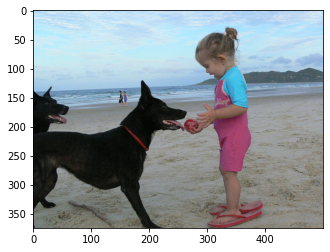

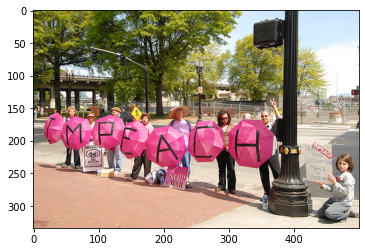

In [45]:
import matplotlib.pyplot as plt

for i in range(2):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

# **ResNet50 Pretrained Model**
1. Using ResNet50 Model to extract image features
2. Create ResNet50 instacnce
3. Create keras Model using ResNet50
4. Extract feature from images

##### Create resnet50 instance

In [46]:
from tensorflow.keras.applications import ResNet50

# incept_model = ResNet50(include_top=True)
img_width, img_height = 224, 224 
incept_model = ResNet50(weights='imagenet', 
                      include_top=True, 
                      input_shape=(img_height, img_width, 3))

##### Create model using keras

In [47]:
from tensorflow.keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

##### Extract image features

In [48]:
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

images_features = {}
count = 0
for i in images:
    img = image.load_img(i, target_size=(img_width, img_height))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    #predict the result
    cnn_feature = incept_model.predict(img_data,verbose=0)
    images_features[i.split('/')[-1]] = cnn_feature  
    count += 1
    if count > 1500: 
        break    

In [49]:
len(images_features)

1501

# **Preprocess .pkl File for captions**
1. Read pkl file
2. Prepare a dictionary of imageName: [captions]

Note: .pkl file must exist on root folder from where program is running

In [50]:
captions = pd.read_pickle('set_0.pkl')
type(captions), len(captions)

(list, 25000)

##### Preparing dictionary

In [51]:
captions_dict = {}
count = 1
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        caption.replace('"', '')
        #         print(img_name, caption)
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]

            else:
                captions_dict[img_name].append(caption) 
    except:
        print("Parse error", img_name, count)
        count += 1
        pass
len(captions_dict)

1492

# **Visualization**
1. Check 2 images with captions
2. Helps to figure out captions dictionary organization

/content/drive/MyDrive/Flicker8k_Dataset/489773343_a8aecf7db3.jpg
/content/drive/MyDrive/Flicker8k_Dataset/476740978_45b65ebe0c.jpg


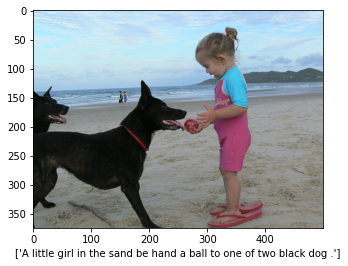

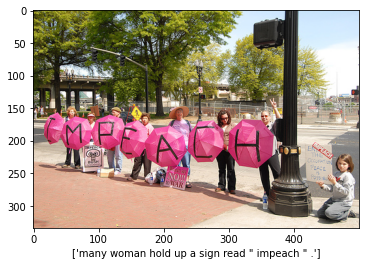

In [52]:
import matplotlib.pyplot as plt

for i in range(2):
    plt.figure()
    img_name = images[i]
    print(img_name)
    img = cv2.imread(img_name)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

##### Method to add start & end tag

In [53]:

def preprocessed(txt):
    modified = txt.lower()
    modified = 'START ' + modified + ' END'
    print(modified)
    return modified
    

##### Preprocessing captions to add start & end tag

In [54]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

START two motorcycle with two rider each . END
START there be two motorcycle with a man and a woman on it . END
START two guy with helmet be on motorcycle , each with a woman ride behind him END
START two motorcycle and four rider be on a road . END
START an old man with long gray hair and a long gray beard bike ride on the shore . END
START a white-bearded man ride a bicycle on a beach . END
START three dog be in the snow in front of a fence . END
START three dog play in the snow . END
START a large dog and two small dog run around in the snow . END
START three dog run around in the snow . END
START a dog be lay on a bed with a blue sheet . END
START a brown dog lay on a blue sheet . END
START a dog lie on a blue cloth dog bed . END
START a brown dog be lay down on a blue sheet . END
START a brown dog lay on a blue cover . END
START basketball player shoot for a goal during a game . END
START four man jump in a basketball game END
START naked child bathe outside under a stream of wate

# **Prepare Vocabulary**

1. Prepare count_words dictionary
2. Prepare new dictionary for encoding captions



In [55]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:
                count_words[word] = 0
            else:
                count_words[word] += 1
len(count_words)                

2550

In [56]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1
        

In [57]:
len(new_dict)

2550

In [58]:
new_dict['<OUT>'] = len(new_dict) 

In [59]:
captions_backup = captions_dict.copy()

In [60]:
captions_dict = captions_backup.copy()

##### Encoding Captions

In [61]:
for k, vv in captions_dict.items():    
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

# **Build Generator Function**
1. Explore caption dictionary items
2. Generate X & y data set using image features & caption dictionary
3. Data from this section to be used in modelling

In [62]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [63]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 2, 5, 6, 7, 8]
[1, 9, 10, 2, 3, 4, 11, 12, 13, 11, 14, 15, 16, 7, 8]
[1, 2, 17, 4, 18, 10, 15, 3, 19, 6, 4, 11, 14, 20, 21, 22, 8]
[1, 25, 26, 12, 4, 27, 28, 29, 13, 11, 27, 28, 30, 31, 20, 15, 32, 33, 7, 8]
[1, 11, 14, 10, 47, 99, 32, 100, 42, 11, 24, 19, 101, 102, 103, 15, 11, 95, 96, 7, 8]
[1, 11, 12, 10, 79, 21, 13, 135, 13, 9, 10, 136, 42, 11, 86, 137, 138, 139, 124, 140, 7, 8]
[1, 11, 114, 38, 4, 11, 53, 198, 199, 200, 201, 39, 11, 202, 42, 51, 72, 4, 11, 197, 39, 203, 204, 7, 8]
[1, 11, 14, 39, 11, 27, 114, 348, 349, 13, 11, 12, 39, 11, 178, 308, 10, 79, 120, 11, 350, 245, 120, 32, 169, 7, 8]
[1, 11, 134, 42, 116, 10, 79, 48, 11, 86, 19, 114, 13, 51, 720, 383, 721, 172, 16, 10, 722, 84, 626, 484, 32, 51, 193, 7, 8]
[1, 11, 996, 149, 12, 158, 304, 997, 13, 11, 998, 441, 230, 11, 999, 73, 11, 393, 39, 124, 755, 437, 105, 154, 11, 1000, 39, 124, 418, 437, 7, 8]
[1, 105, 200, 114, 38, 10, 69, 11, 202, 19, 440, 114, 38, 4, 11, 178, 198, 15, 203, 177, 10, 65, 484, 11, 164

In [64]:
MAX_LEN

36

In [65]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k][0])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out
    
    

In [66]:
X, y_in, y_out = generator(images_features, captions_dict)

In [67]:
len(X), len(y_in), len(y_out)

(60102, 60102, 60102)

In [68]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [69]:
X.shape, y_in.shape, y_out.shape

((60102, 1000), (60102, 36), (60102, 2551))

In [70]:
len(X[5])

1000

# **Modelling**
1. Hyper parameter tuning
2. Saving the model
3. Model after training will be used of predictions

In [71]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
#from tensorflow.keras.layers.merge import add
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [72]:
import tensorflow as tf
# def hypertuning(params):
#     print("===>", params)
#     embedding_size = params[0]
#     max_len = MAX_LEN
#     vocab_size = len(new_dict)

#     image_model = Sequential()

#     image_model.add(Dense(embedding_size, input_shape=(1000,), activation='relu',kernel_regularizer=regularizers.l1(0.01)))
# #     image_model.add(Dropout(0.25))
#     image_model.add(RepeatVector(max_len))

# #     image_model.summary()

#     language_model = Sequential()

#     language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
# #     language_model.add(Dropout(0.10))
#     language_model.add(LSTM(params[1], return_sequences=True))
#     language_model.add(TimeDistributed(Dense(embedding_size)))

# #     language_model.summary()
    
#     #Concat image and language model
#     conca = Concatenate()([image_model.output, language_model.output])
# #     x = LSTM(128, return_sequences=True)(conca)
# #     x = LSTM(512, return_sequences=False)(x)
#     x = LSTM(params[2], activation="relu", return_sequences=True, kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01))(conca)
#     x = LSTM(params[3], activation="relu", return_sequences=True, kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01))(x)
#     x = LSTM(params[4], activation="relu", return_sequences=True, kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01))(x)
#     x = LSTM(params[5], activation="relu", return_sequences=True, kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01))(x)
#     x = LSTM(params[6], activation="relu", return_sequences=False, kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01))(x)
#     x = Dense(vocab_size)(x)
#     out = Activation('softmax')(x)
#     model = Model(inputs=[image_model.input, language_model.input], outputs = out)

#     #Set Learning rate
#     opt = ""
#     if (params[7] == "Adam"):
#         opt = tf.keras.optimizers.Adam(learning_rate=0.01)
#     elif (params[7] == "SGD"):
#         opt = tf.keras.optimizers.SGD(learning_rate=0.01)
#     elif (params[7] == "RMSprop"):
#         opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    

#     #Compiling the model
#     model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# #     model.summary()

#     #Fitting the model
#     history = model.fit([X, y_in], y_out, batch_size=params[8], epochs=params[9], validation_split=0.2)
    
#     return history, model
    

In [73]:
# hparams1 = [64, 128, 64, 128, 256, 512, 1024, 'RMSprop', 256, 10]
# hparams2 = [128, 256, 128, 256, 512, 256, 512, 'Adam', 256, 10]
# hparams3 = [128, 256, 128, 256, 512, 512, 512, 'SGD', 128, 10]
# hparams4 = [128, 256, 128, 256, 512, 512, 512, 'RMSprop', 128, 10]
# hparams5 = [128, 256, 128, 256, 512, 512, 512, 'RMSprop', 512, 10]

# h1, model1 = hypertuning(hparams1)
# h2, model2 = hypertuning(hparams2)
# h3, model3 = hypertuning(hparams3)
# h4, model4 = hypertuning(hparams4)
# h5, model5 = hypertuning(hparams5)

In [74]:
inv_dict = {v:k for k, v in new_dict.items()}

In [75]:
# pd.DataFrame(h1.history).plot(figsize=(4,4), xlabel='Model Loss')
# pd.DataFrame(h2.history).plot(figsize=(4,4), xlabel='Model Loss')
# pd.DataFrame(h3.history).plot(figsize=(4,4), xlabel='Model Loss')
# pd.DataFrame(h4.history).plot(figsize=(4,4), xlabel='Model Loss')
# pd.DataFrame(h5.history).plot(figsize=(4,4), xlabel='Model Loss')

In [76]:
embedding_size1 = 128
max_len1 = MAX_LEN
vocab_size1 = len(new_dict)

image_model1 = Sequential()

image_model1.add(Dense(embedding_size1, input_shape=(1000,), activation='relu'))
image_model1.add(RepeatVector(max_len1))

# image_model.summary()

language_model1 = Sequential()

language_model1.add(Embedding(input_dim=vocab_size1, output_dim=embedding_size1, input_length=max_len1))
language_model1.add(LSTM(256, return_sequences=True))
language_model1.add(TimeDistributed(Dense(embedding_size1)))

# language_model.summary()

concate = Concatenate()([image_model1.output, language_model1.output])
x = LSTM(128, return_sequences=True)(concate)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size1)(x)
out = Activation('softmax')(x)
model11 = Model(inputs=[image_model1.input, language_model1.input], outputs = out)

model11.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# model.summary()
model11.fit([X, y_in], y_out, batch_size=512, epochs=10)


Epoch 1/10
118/118 [==============================] - 27s 178ms/step - loss: 5.0641 - accuracy: 0.1536
Epoch 2/10
118/118 [==============================] - 21s 177ms/step - loss: 4.5738 - accuracy: 0.2164
Epoch 3/10
118/118 [==============================] - 21s 178ms/step - loss: 4.3493 - accuracy: 0.2509
Epoch 4/10
118/118 [==============================] - 21s 176ms/step - loss: 4.2650 - accuracy: 0.2622
Epoch 5/10
118/118 [==============================] - 21s 177ms/step - loss: 4.1414 - accuracy: 0.2686
Epoch 6/10
118/118 [==============================] - 21s 177ms/step - loss: 4.0039 - accuracy: 0.2856
Epoch 7/10
118/118 [==============================] - 21s 177ms/step - loss: 3.8376 - accuracy: 0.3110
Epoch 8/10
118/118 [==============================] - 21s 177ms/step - loss: 3.6954 - accuracy: 0.3279
Epoch 9/10
118/118 [==============================] - 21s 177ms/step - loss: 3.5653 - accuracy: 0.3405
Epoch 10/10
118/118 [==============================] - 21s 177ms/step - l

In [77]:
def getImage(x):
    
    # test_img_path = images[x]

    test_img = cv2.imread(x)#test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

# **Predictions**

**Download any image from google images and name that images "test1.jpg"
Keep the file in location './testimages/test1.jpg' from where code is running** 

Text(0.5, 0, ' a black dog be jump through a field . END')

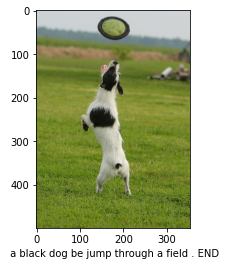

In [78]:
test_img_path = './testimages/test1.jpg'

test_feature = incept_model.predict(getImage(test_img_path)).reshape(1,1000)

test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


text_inp = ['START']

count = 0
caption = ''
while count < 25:
    count += 1

    encoded = []
    for i in text_inp:
        encoded.append(new_dict[i])

    encoded = [encoded]

    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


    prediction = np.argmax(model11.predict([test_feature, encoded]))

    sampled_word = inv_dict[prediction]
   
    caption = caption + ' ' + sampled_word
    
    if sampled_word == 'END':
        break
    text_inp.append(sampled_word)

plt.figure()
plt.imshow(test_img)
plt.xlabel(caption)